**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

### Camera Calibration
I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `obj` is just a replicated array of coordinates, and `object_points` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `image_points` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `object_points` and `image_points` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  

In [3]:
def calibrate_camera(path):
    object_points=[]
    image_points=[]
    images=glob.glob(path)
    img_size=()
    obj=np.zeros((9*6,3),np.float32)
    obj[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
    for idx,image in enumerate(images):
        img=cv2.imread(image)
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret,corners=cv2.findChessboardCorners(gray,(9,6),None)
        if ret:
            image_points.append(corners)
            object_points.append(obj)
        img_size=(img.shape[1],img.shape[0])
    ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(object_points,image_points,img_size,None,None)
    return mtx,dist 


In [4]:
mtx,dist=calibrate_camera('./camera_cal/calibration*.jpg')


In the previous step I calculated *Camera Matrix* and *Distortion Coefficients* using `cv2.calibrateCamera` now I can use these values to undistort any image taken from the same camera using `cv2.undistort`. The result after distorting image looks like this:

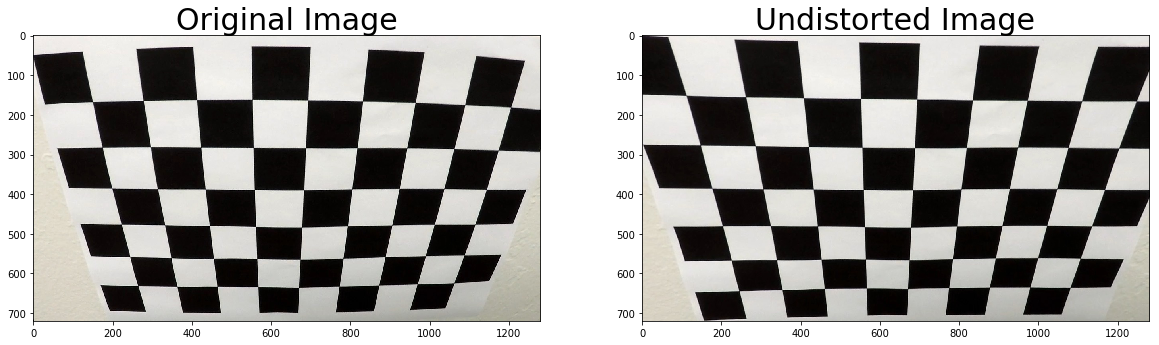

In [5]:
test_image=cv2.imread('./camera_cal/calibration2.jpg')
undistort=cv2.undistort(test_image,mtx,dist,None,mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(undistort,cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

### Perspective Transform
I started with choosing four reference points in the image to use them as `src_points` and four points for `dest_points`. The source points reflects on destination points after the perspective transform. The first step is to calculate the transformation matrix using `cv2.getPerspectiveTransform()` this function takes source and destination points as input.

| Source        | Destination   | 
|:-------------:|:-------------:| 
|  200, 720     | 300, 720      | 
|  600, 447     | 300, 0        |
|  679, 447     | 900, 0        |
|  1100,720     | 900, 720      |

In [6]:
#function to calculate transformation matrix for perspective transform.
def get_transformation_matrix(src,dest):
    transformation_matrix=cv2.getPerspectiveTransform(src,dest)
    return transformation_matrix

In [7]:
#warp the image
def perspective_transform(image,transformation_matrix):
    img_size=(image.shape[1],image.shape[0])
    transformed_image=cv2.warpPerspective(image,transformation_matrix,img_size,flags=cv2.INTER_LINEAR)
    return transformed_image

#### Perform Perspective Transform
Once we have the transformation matrix we can use `cv2.warpPerspective` to perform perspective transform of an image. The result after the transform looks like this. 

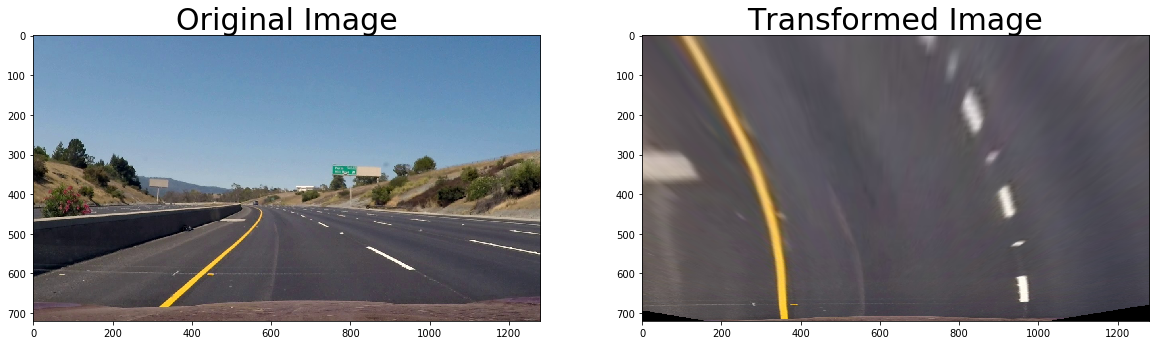

In [8]:
#undistort Image
transformation_test=cv2.imread('./frames/frame2.jpg')
undistort=cv2.undistort(transformation_test,mtx,dist,None,mtx)


#src_points=np.float32([[790,490],[1090,670],[250,670],[515,490]])
#dest_points=np.float32([[1100,0],[1100,720],[200,720],[200,0]])
#src_points=np.float32([[800,490],[1100,650],[210,650],[500,490]])
#dest_points=np.float32([[1100,0],[1100,720],[200,720],[200,0]])

#perform perspective transform
src_points = np.float32([[200,720], [600, 447], [679,447], [1100,720]])
dest_points = np.float32([[300, 720], [300, 0], [900, 0], [900, 720]])
transformation_matrix=get_transformation_matrix(src_points,dest_points)
transformed_image=perspective_transform(undistort,transformation_matrix)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(transformation_test,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(transformed_image,cv2.COLOR_BGR2RGB))
ax2.set_title('Transformed Image', fontsize=30)

### Image Thresholding
After trying different strategies to apply thresholding finally I applied HLS Colour space and Sobel thresholding to fecth features of interest from the frame, here features of intrest are Lane lines. I used Sobel along the X axis that is `sobelx` and later applied thresholding over it, and I also applied thresholding over HLS colour space to get a binary image. 
*Values for Thresholding*

| Applied On    | Range         | 
|:-------------:|:-------------:| 
|  Sobel X      | 25 - 120      | 
|  l_channel    | 70 - 255       |
|  s_channel    | 90 - 255        |


In [9]:
def apply_sobel(image,thresholds,kernel_size=3,Color_Encoding='RGB'):
    if(Color_Encoding=='BGR'):
        gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    else:
        gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
  
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=kernel_size)
    sobel_scaled=np.uint8(255*np.absolute(sobelx)/np.max(sobelx))
    binary_image=np.zeros_like(sobel_scaled)
    binary_image[(sobel_scaled>=thresholds[0]) & (sobel_scaled<=thresholds[1])]=1
    return binary_image

In [10]:
def apply_sobel_and_color_thresholding(image,thresholds_sobel,threshold_l,thresholds_s,kernel_size=3,Color_Encoding='RGB'):
    
    if(Color_Encoding=='BGR'):
        gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        hls=cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    else:
        gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        hls=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    s_channel=hls[:,:,2]
    l_channel=hls[:,:,1]
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=kernel_size)
    scaled_sobel=np.uint8(255*np.absolute(sobelx)/np.max(sobelx))
    binary_image=np.zeros_like(scaled_sobel)
    binary_image[((scaled_sobel>=thresholds_sobel[0]) & (scaled_sobel<=thresholds_sobel[1]))|((hls[:,:,2]>=thresholds_s[0]) & (hls[:,:,2]<=thresholds_s[1]) & (hls[:,:,1]>=threshold_l[0]) & (hls[:,:,1]<=threshold_l[1]))]=1
    return binary_image

In [11]:
def apply_sobel_direction(image,thresholds_sobel,thresholds_direction,kernel_size=3,Color_Encoding='RGB'):
    if(Color_Encoding=='BGR'):
        gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    else:
        gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=kernel_size)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=kernel_size)
    sobel_direction=np.arctan2(np.absolute(sobelx),np.absolute(sobely))
    sobel_scaled=np.uint8(255*np.absolute(sobelx)/np.max(sobelx))
    binary_image=np.zeros_like(sobel_scaled)
    binary_image[(sobel_direction>=thresholds_direction[0]) & (sobel_direction<=thresholds_direction[1]) &(sobel_scaled>=thresholds_sobel[0]) & (sobel_scaled<=thresholds_sobel[1])]=1
    return binary_image
    

In [12]:
def color_thresholding(image,l_threshold,s_threshold):
    hls=cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    binary_image=np.zeros_like(hls[:,:,0])
    binary_image[(hls[:,:,2]>=s_threshold[0]) & (hls[:,:,2]<=s_threshold[1]) & (hls[:,:,1]>=l_threshold[0]) & (hls[:,:,1]<=l_threshold[1])]=1
    return binary_image

#### Test Thresholding
Below is the image that my function returns after applying thresholding over it:

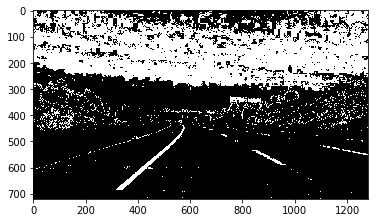

In [13]:
binary_image=apply_sobel_and_color_thresholding(transformation_test,[25,120],[70,255],[90,255])
plt.imshow(binary_image,cmap='gray')

### Thresholding and Perspective Transform
Below is the result that my pipeline returned after applying thresholding and later performing perspective transform:

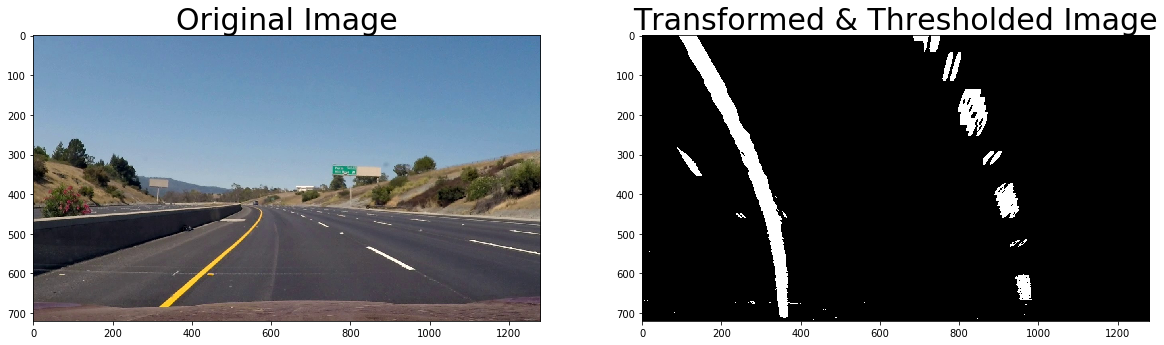

In [14]:


transformed_image=perspective_transform(binary_image,transformation_matrix)
output_image=np.dstack((transformed_image,transformed_image,transformed_image))*255


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(transformation_test,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(output_image)
ax2.set_title('Transformed & Thresholded Image', fontsize=30)

### Pipeline
I used a class to retain the data from previous frames, my pipeline function is also a member of this class.
Steps performed:
    1. For the First Frame calculate Camera matrix, distortion Coefficients, transformation matrix and inverse transformation matrix.
    2. Undistort the Image
    3. Apply Thresholding
    4. Take Perspective Transform
    5. Find out the pixel indices that are part of lane lines.
    6. Fit the polynomial to the left and right lane pixels.
    7. Take the mean of the previous polynomial coefficients and the coefficeint calculated in step 6.
    8. Calculate the x points for each value of Y(0-719) using the equation AY^2+BY+C.
    9. Then using `cv2.fillPoly()` fill the lane line area.
    10. Take the inverse Perspective transform of the image received from step 9.
    11. Add the original image and image from step 10.
    12. Calculate Radius of curvature and deviation from center and put it over the image received after step 12.
    
### Deviation from center
To calculate the deviation from center I assumed that the center of the image is the center of the car, then I simply calculated the center of the lane lines and the differnce between center of the image and center of the lane lines is required deviation.

In [32]:
class LaneLineFinding(object):
    #prev_left_x=np.array([])
    #prev_left_y=np.array([])
    #prev_right_x=np.array([])
    #prev_right_y=np.array([])
    prev_left_coeff=np.array([])
    prev_right_coeff=np.array([])
    last_left_fit=[]
    last_right_fit=[]
    mtx=None
    dist=None
    trans_matrix=None
    inverse_trans_matrix=None
    flag=True
    def pipeline(self,image):
        if(self.flag):
            self.mtx,self.dist,self.trans_matrix,self.inverse_trans_matrix=get_variables()
        undistort=cv2.undistort(image,self.mtx,self.dist,None,self.mtx)
        #binary_image=apply_sobel_and_color_thresholding(transformed_image,[12,170],[48,255])
        #binary_image=color_thresholding(undistort,[75,255],[85,255])
        binary_image=apply_sobel_and_color_thresholding(undistort,[25,120],[70,255],[90,255])#[70,120],[120,255],[90,255])#[70,120],[100,255],[90,255])#[25,150],[90,255],[90,255])
        transformed_image=perspective_transform(binary_image,self.trans_matrix)
        if(self.flag):
            self.flag=False
            left_x,left_y,right_x,right_y=sliding_window(transformed_image)
        else:
            left_x,left_y,right_x,right_y=find_lane_lines(transformed_image,self.last_left_fit,self.last_right_fit)
        
        
        #output= np.dstack((transformed_image,np.zeros_like(binary_image),np.zeros_like(binary_image)))*255
        #plt.imshow(binary_image)
        #print(output)
        #if(len(self.prev_left_x)>=720*10):
        #    self.prev_left_x=self.prev_left_x[720:len(self.prev_left_x)]
        #if(len(self.prev_right_x)>=720*10):
        #    self.prev_right_x=self.prev_right_x[720:len(self.prev_right_x)]
        #if(len(self.prev_left_y)>=720*10):
        #    self.prev_left_y=self.prev_left_y[720:len(self.prev_left_y)]
        #if(len(self.prev_right_y)>=720*10):
        #    self.prev_right_y=self.prev_right_y[720:len(self.prev_right_y)]
        
        #self.prev_left_x=np.append(self.prev_left_x,left_x)
        
        #self.prev_left_y=np.append(self.prev_left_y,left_y)
        #self.prev_right_x=np.append(self.prev_right_x,right_x)
        #self.prev_right_y=np.append(self.prev_right_y,right_y)
       
        #left_fit=np.polyfit(self.prev_left_y, self.prev_left_x,2)
        #right_fit=np.polyfit(self.prev_right_y,self.prev_right_x,2)
        
        left_fit=np.polyfit(left_y, left_x,2)
        right_fit=np.polyfit(right_y,right_x,2)
        
        
        
        if(len(self.prev_left_coeff)>=10*3):
            self.prev_left_coeff=self.prev_left_coeff[3:len(self.prev_left_coeff)]
        if(len(self.prev_right_coeff)>=3*10):
            self.prev_right_coeff=self.prev_right_coeff[3:len(self.prev_right_coeff)]
       
        self.prev_right_coeff=np.append(self.prev_right_coeff,right_fit)
        self.prev_left_coeff=np.append(self.prev_left_coeff,left_fit)
        
       
        left_fit=np.mean(self.prev_left_coeff.reshape(-1,3),axis=0)
        right_fit=np.mean(self.prev_right_coeff.reshape(-1,3),axis=0)
        self.last_left_fit=left_fit
        self.last_right_fit=right_fit
       
    
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        output_image=np.zeros_like(image)
       
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
    # Draw the lane onto the warped blank image
        cv2.fillPoly(output_image, np.int_([pts]), (0, 255, 0))
        final_image=perspective_transform(output_image,self.inverse_trans_matrix)
        output_image=cv2.addWeighted(image,1,final_image,0.5,0)
        
        
        #left_curverad,right_curverad=calculate_radius_of_curvature(left_fit,right_fit,np.max(ploty))
        left_curverad,right_curverad=calculate_radius_of_curvature(left_fitx,right_fitx,image.shape)
        cv2.putText(output_image,'Radius Of Curvature = {0:.2f}(m)'.format(np.mean([left_curverad,right_curverad])),(50,50), 2, 1,(255,255,255),2,cv2.LINE_AA)
        deviation_from_center=((image.shape[1]/2) - (((np.absolute(right_fitx[-1]-left_fitx[-1]))/2)+left_fitx[-1]))*(3.7/600)
        if(deviation_from_center>0):
            cv2.putText(output_image,'vehicle is {0:.2f}(m) left from the center'.format(np.absolute(deviation_from_center)),(50,100), 2, 1,(255,255,255),2,cv2.LINE_AA)
        else:
            cv2.putText(output_image,'vehicle is {0:.2f}(m) right from the center'.format(np.absolute(deviation_from_center)),(50,100), 2, 1,(255,255,255),2,cv2.LINE_AA)
        return output_image

### Sliding Window
I have used sliding window approach to find out the indices of the pixels those are part of the lane lines. This approach uses a window and only considers nonzero pixels within that window, in my implementaion I have used 9 windows hence there will be 9 windows for left lane and 9 windows for right lane, each of 80 pixel height and 200 pixels width. 
This function returns the `left_x`,`left_y` for left lane and `right_x`,`right_y` for right lane. These points I used in Pipeline to fit a polynomial.

Sliding window is not being used by each frame, since consecutive frames will not have much difference in  lane line positions, hence we are serching in a given margin for the next frame say 100 in my case. I have defined `find_lane_lines()` for this purpose this function also returns the `left_x`,`left_y` for left lane and `right_x`,`right_y` for right lane. These points I used in Pipeline to fit a polynomial.

In [16]:
def sliding_window(binary_warped,visualize=False):
    histogram=np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if(visualize):
    # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        return None
    return leftx,lefty,rightx,righty

In [17]:
def find_lane_lines(binary_warped,left_fit,right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return leftx,lefty,rightx,righty

#### Fit the Polynomial
Below is the result after identifying the lane line points and fitting a polynomial to them.

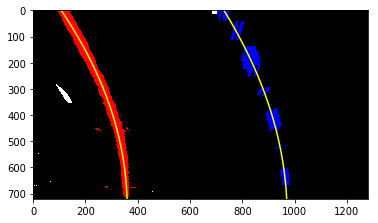

In [18]:
sliding_window(transformed_image,visualize=True)

In [19]:
def get_variables():
    mtx,dist=calibrate_camera('./camera_cal/calibration*.jpg')
    
    #1src_points=np.float32([[800,470],[1100,720],[210,720],[500,470]])
    #1dest_points=np.float32([[1100,0],[1100,720],[200,720],[200,0]])
    #src_points=np.float32([[790,490],[1090,670],[250,670],[515,490]])
    #dest_points=np.float32([[1100,0],[1100,720],[200,720],[200,0]])
    
    
    src_points = np.float32([[200,720], [600, 447], [679,447], [1100,720]])
    dest_points = np.float32([[300, 720], [300, 0], [900, 0], [900, 720]])
    
    
    transformation_matrix=get_transformation_matrix(src_points,dest_points)
    inverse_transformation_matrix=get_transformation_matrix(dest_points,src_points)
    return  mtx,dist,transformation_matrix,inverse_transformation_matrix


### Radius of curvature
Once we have the polynomial coefficients we can use them to find out the radius of curvature. I have scaled the Radius of curvature in the meters. 

In [40]:
def calculate_radius_of_curvature(leftx,rightx,shape):
    ym_per_pix = 43/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/600 # meters per pixel in x dimension
    ploty = np.linspace(0, shape[0]-1, shape[0] )
    y_eval=np.max(ploty)
    # Fit new polynomials to x,y in world space
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad
    # Example values: 632.1 m    626.2 m

### Pipeline Output
Below is the example of Pipeline output for a frame.

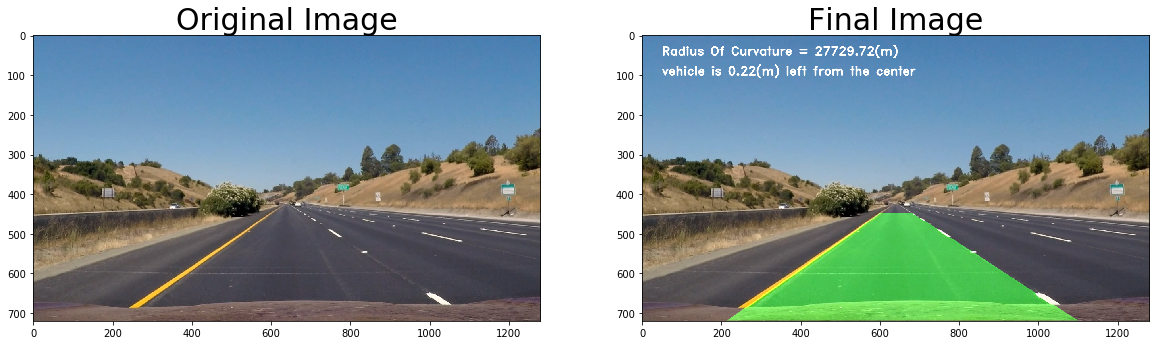

In [41]:
import matplotlib.image as matimage
test=LaneLineFinding()
test_image=matimage.imread('./test_images/straight_lines1.jpg')
test_output=test.pipeline(test_image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_output)
ax2.set_title('Final Image', fontsize=30)

In [42]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_processor=LaneLineFinding()
white_output = 'project_video_output.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_processor.pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:09<00:00,  7.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 12s
